#  The number of taxi orders for the next hour forecasting

The company collected historical data on taxi orders at airports. To attract more drivers during peak load, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric in the test sample should be no more than 48.

We need to:

1. Download the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the file `taxi.csv'. The number of orders is in the `num_orders` column.

Importing the libraries necessary for the work:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

## Preparation

Let's look at the data:

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.head(3)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28


Let's make the date an index and define it as **`datetime`**

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Let's check whether the sorting has turned out and whether the indexes are in chronological order

In [4]:
if df.index.is_monotonic == True:
    print('Indexes are sorted')
else:
    print('An error in the chronology')

Indexes are sorted


Let's perform resampling **`one hour at a time`**

In [5]:
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Conclusion:**
- read the data
- converted the date to the required format **`datetime`**
- for further work, the date was made an index
- made resampling of data by the hour

## Analysis

Let's do an EDA, we don't have much data, so let's take a closer look at the time series.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


Number of orders by hour:
- takes values from 0 to 462
- with an average of 84 orders per hour
- standard deviation 45

Now let's look at the charts:

In [7]:
def plot_time(data, nm):
    plt.figure(figsize = (14, 4))

    plt.plot(data)

    plt.title(nm)

    plt.xlabel('date')
    plt.ylabel('cnt_sum')
    plt.grid(True)
    plt.show()

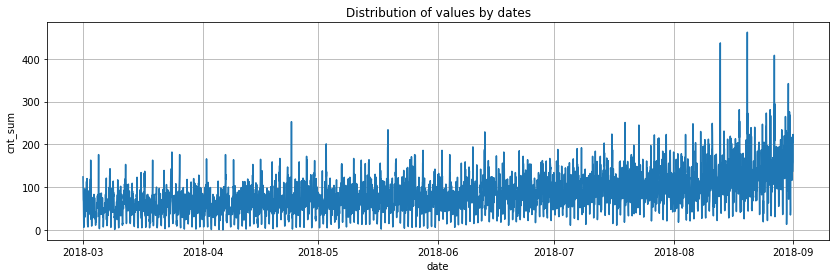

In [8]:
plot_time(df, 'Distribution of values by dates')

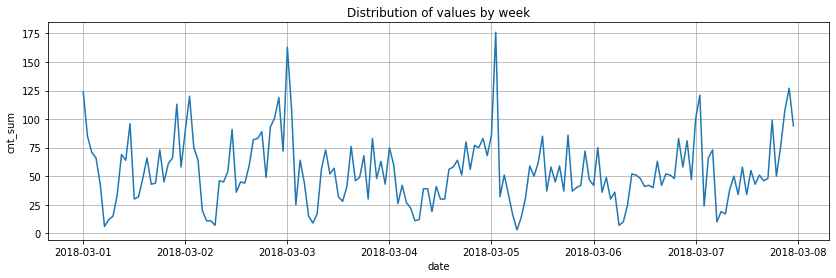

In [9]:
plot_time(df.head(24*7), 'Distribution of values by week')

Use the **seasonal_decompose()** function and select the components of the time series:

   - `decomposed.trend` — trend
   - `decomposed.seasonal` — seasonal component
   - `decomposed.resid` — decomposition remainder

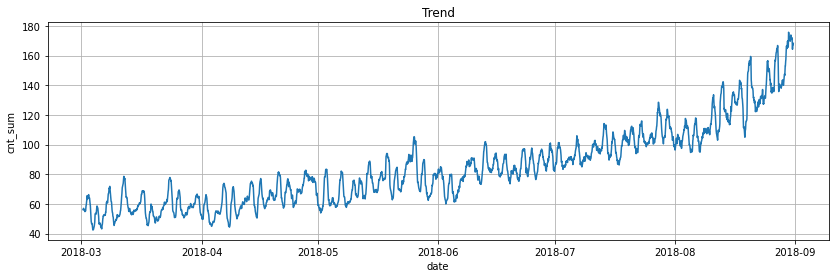

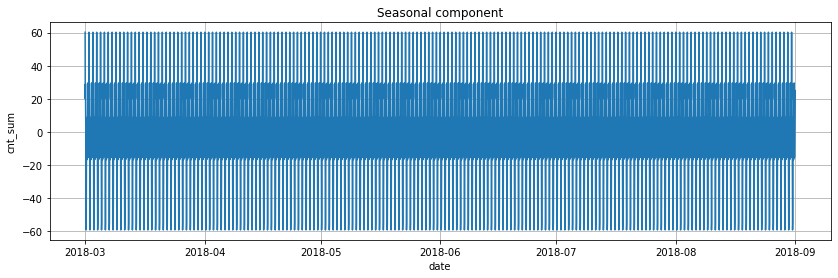

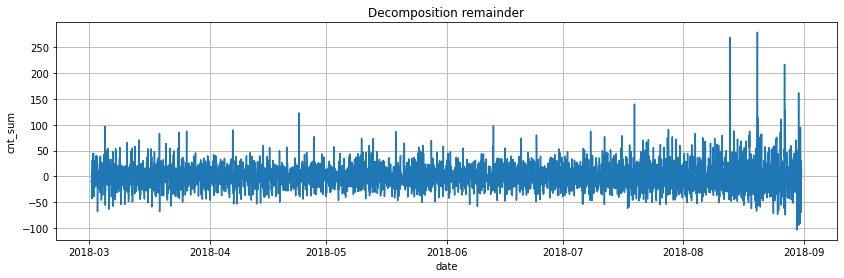

In [10]:
decomposed = seasonal_decompose(df)

list_grph = {'Trend': decomposed.trend, 
             'Seasonal component': decomposed.seasonal, 
             'Decomposition remainder': decomposed.resid}

for i in list_grph:
    plot_time(list_grph[i], i)

The graphs show:
   - the number of orders is growing over time (trend chart) - taxi business is going uphill
   - the remainder of the decomposition (noise) is stationary, except for the period *2018-08 - 2018-09*, with an uptrend, the remainder is growing (it looks logical)
   - let's look at the seasonal component on a different scale
   
   
`Stationary time series` are series in which the mean and standard deviation do not change

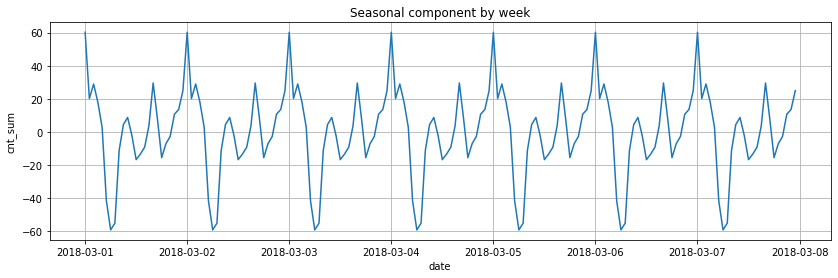

In [11]:
plot_time(decomposed.seasonal.head(24*7), 'Seasonal component by week')

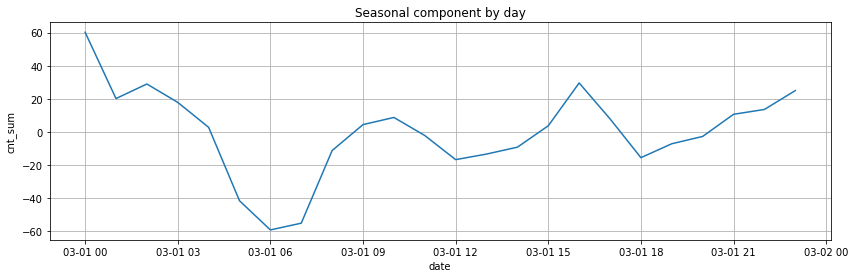

In [12]:
plot_time(decomposed.seasonal.head(24), 'Seasonal component by day')

It turns out quite clearly:
- seasonality is associated with days, which is quite logical
- the spread of the target variable is 120 on a weekly scale
- if you look at the daily scale, the peak hours at 9 am and 16 pm are highlighted

**Conclusion:**
- studied the data in more detail
- anomalies and omissions have not been identified
- split the time trend, seasonality and remainder into components and viewed them at different scales

## Training

### Data preprocessing

**The main objective of the project:**

It is necessary to predict the number of taxi orders for the next hour

**Target variable:**

`num_orders` - set by condition

**What type of task is being solved:**

A quantitative feature is predicted, we solve the regression problem

**Quality metric:**

RSME - set by condition

**Feature generation**

Before training the model and selecting parameters, we need to generate features:
- `Calendar signs` - year, month, day of the week, day, hour
- `Lagging values` - previous values of the time series will tell you whether the function x(t) will grow or decrease
- `Moving average` - smoothing of time series. The essence is to find the values that are least susceptible to fluctuations, that is, arithmetic averages.


We will write a function for creating features, in our project it is important to take into account, including hours, so we will optionally add their accounting to the feature generation function.

In [13]:
def make_features(df, max_lag, rolling_mean_size, flg_hour):
    
    data = df.copy()

    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    if flg_hour == True:
        hour = data.index.hour
        data['hour'] = hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data
    
    
df_tst = make_features(df, 4, 4, 1)

So we wrote a function to generate features (checked its operation and output test values)

Now we need to decide on which combination of features we will teach our models and compare their results.

**Idea:**

Make an improvised GridSearch on the base model:
   - try different combinations
   - view the metric on the test
   - choose the best combination
 
As a *baseline model*, I propose to take linear regression (*there are no surprises here - it learns very quickly*).

In [14]:
%time

res_df = pd.DataFrame()

for max_lag in range(10, 41, 10):
    for rolling_mean_size in range(5, 21, 5):
        for flg_hour in range(2):
            
            df_test = make_features(df, max_lag, rolling_mean_size, bool(flg_hour))
            
            train, test = train_test_split(
                    df_test,
                    test_size = 0.1, 
                    random_state = 12345,
                    shuffle = False
                   )
                
            train = train.dropna() 
                  
            X_train = train.drop(['num_orders'], axis=1)
            y_train = train['num_orders']

            X_test = test.drop(['num_orders'], axis=1)
            y_test = test['num_orders']
            
            model_lr = LinearRegression()
            model_lr.fit(X_train, y_train)

            y_pred = model_lr.predict(X_test)

            search_df = {'max_lag': [max_lag],
                         'rolling_mean_size': [rolling_mean_size],
                         'flg_hour': [flg_hour],
                         'rmse': [mean_squared_error(y_pred, y_test) ** 0.5]
                        }
            
            res_df = pd.concat([res_df, pd.DataFrame(search_df)], ignore_index = True)
            
            print('max_lag: {}, rolling_mean_size: {}, flg_hour: {}, RMSE: {}'.format(
                max_lag, rolling_mean_size, flg_hour ,mean_squared_error(y_pred, y_test) ** 0.5))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
max_lag: 10, rolling_mean_size: 5, flg_hour: 0, RMSE: 53.623838361403806
max_lag: 10, rolling_mean_size: 5, flg_hour: 1, RMSE: 53.454643856732545
max_lag: 10, rolling_mean_size: 10, flg_hour: 0, RMSE: 53.62383836140376
max_lag: 10, rolling_mean_size: 10, flg_hour: 1, RMSE: 53.454643856732545
max_lag: 10, rolling_mean_size: 15, flg_hour: 0, RMSE: 54.19492856610559
max_lag: 10, rolling_mean_size: 15, flg_hour: 1, RMSE: 53.97908360958351
max_lag: 10, rolling_mean_size: 20, flg_hour: 0, RMSE: 56.30491421060951
max_lag: 10, rolling_mean_size: 20, flg_hour: 1, RMSE: 56.06755778424661
max_lag: 20, rolling_mean_size: 5, flg_hour: 0, RMSE: 55.23993109743643
max_lag: 20, rolling_mean_size: 5, flg_hour: 1, RMSE: 54.43628578201461
max_lag: 20, rolling_mean_size: 10, flg_hour: 0, RMSE: 55.239931097436596
max_lag: 20, rolling_mean_size: 10, flg_hour: 1, RMSE: 54.436285782014586
max_lag: 20, rolling_mean_size: 15, flg_hour: 0, RMSE: 55.23

Choosing the best parameters:

In [15]:
res_df = res_df.sort_values(by = 'rmse', ascending = True).head(1)
res_df

,max_lag,rolling_mean_size,flg_hour,rmse
17,30,5,1,46.858281


We are collecting the final dataset on which we will train the models:   

In [16]:
df_test = make_features(df, list(res_df['max_lag'])[0], 
                            list(res_df['rolling_mean_size'])[0],
                            list(res_df['flg_hour'])[0])

train, test = train_test_split(df_test, shuffle = False, test_size = 0.1)
train = train.dropna()


X_train = train.drop(columns = ['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(columns = ['num_orders'], axis=1)
y_test = test['num_orders']

### Model training

In [17]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better = False
)

In [18]:
ts_cv = TimeSeriesSplit(n_splits = 5)

#### Linear regression

In [19]:
%%time

t1 = datetime.datetime.now()

model_lr = LinearRegression()

scores_lr = np.array([])

scores_on_this_split = cross_val_score(
            estimator = model_lr , X = X_train, y = y_train,
            cv = ts_cv, scoring = rmse_scorer)

scores_lr = np.append(scores_lr, scores_on_this_split)

t2 = datetime.datetime.now()

time_lr = round((t2-t1).total_seconds(), 1)

time_lr_cv = round((t2-t1).total_seconds(), 1)

scores_lr

CPU times: user 267 ms, sys: 144 ms, total: 411 ms
Wall time: 40.7 ms


array([-23.2183007 , -23.47032418, -25.18129987, -27.21956321,
       -33.44048881])

Training the model

In [20]:
%%time

t1 = datetime.datetime.now()

model_lr.fit(X_train, y_train)

t2 = datetime.datetime.now()

time_lr_fit = round((t2-t1).total_seconds(), 1)

CPU times: user 15.3 ms, sys: 37.6 ms, total: 52.9 ms
Wall time: 5.63 ms


Making a prediction

In [21]:
%%time

t1 = datetime.datetime.now()

predicted_target_test_lr = model_lr.predict(X_test)

t2 = datetime.datetime.now()

time_lr_prd = round((t2-t1).total_seconds(), 1)

CPU times: user 4.32 ms, sys: 11.1 ms, total: 15.4 ms
Wall time: 1.73 ms


In [22]:
score_lr = mean_squared_error(y_test, predicted_target_test_lr) ** 0.5
score_lr

46.858281157799155

#### Random Forest

In [23]:
model_rf = RandomForestRegressor(random_state = 12345)

In [24]:
param_grid_rf = { 
    'max_depth' : [4,5,6,7,8,9,10,11,12,13,14,15,16, 17, 18, 19, 20],
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

In [25]:
%%time

t1 = datetime.datetime.now()

CV_rf = GridSearchCV(estimator = model_rf, param_grid = param_grid_rf, cv = 5, 
                                                  scoring = rmse_scorer)
CV_rf.fit(X_train, y_train)

print("Best param RF")
print(CV_rf.best_params_)

model_rf.set_params(**CV_rf.best_params_)


scores_rf = np.array([])

scores_on_this_split = cross_val_score(
            estimator = model_rf , X = X_train, y = y_train,
            cv = ts_cv, scoring = rmse_scorer)

scores_rf = np.append(scores_rf, scores_on_this_split)

t2 = datetime.datetime.now()

time_rf_cv = round((t2-t1).total_seconds(), 1)

Best param RF
{'max_depth': 12, 'n_estimators': 15}
CPU times: user 5min 20s, sys: 1.36 s, total: 5min 22s
Wall time: 5min 22s


Training the model

In [26]:
%%time

t1 = datetime.datetime.now()

model_rf.fit(X_train, y_train)

t2 = datetime.datetime.now()

time_rf_fit = round((t2-t1).total_seconds(), 1)

CPU times: user 604 ms, sys: 2.18 ms, total: 606 ms
Wall time: 605 ms


Making a prediction

In [27]:
%%time

t1 = datetime.datetime.now()

predicted_target_test_rf = model_rf.predict(X_test)

t2 = datetime.datetime.now()

time_rf_prd = round((t2-t1).total_seconds(), 1)

CPU times: user 3.86 ms, sys: 927 µs, total: 4.79 ms
Wall time: 3.97 ms


In [28]:
score_rf = mean_squared_error(y_test, predicted_target_test_rf) ** 0.5
score_rf

45.11128118765155

#### CatBoost

In [29]:
model_catbst = CatBoostRegressor(random_state = 12345, 
                                 verbose = False, 
                                 loss_function='RMSE') 

In [30]:
param_grid_catbst = {'learning_rate':[0.1, 0.5, 0.8], 'iterations': [20, 40, 60, 80, 100]}

In [31]:
%%time

t1 = datetime.datetime.now()
CV_catbst = GridSearchCV(estimator = model_catbst, param_grid = param_grid_catbst, cv = 5, 
                                                  scoring = rmse_scorer)
CV_catbst.fit(X_train, y_train)

print("Best param Catbst")
print(CV_catbst.best_params_)

model_catbst.set_params(**CV_catbst.best_params_)

scores_catbst = np.array([])

scores_on_this_split = cross_val_score(
            estimator = model_catbst , X = X_train, y = y_train,
            cv = ts_cv, scoring = rmse_scorer)
scores_catbst = np.append(scores_catbst, scores_on_this_split)

t2 = datetime.datetime.now()

time_catbst_cv = round((t2-t1).total_seconds(), 1)

Best param Catbst
{'iterations': 100, 'learning_rate': 0.1}
CPU times: user 1min 27s, sys: 1.69 s, total: 1min 28s
Wall time: 9.49 s


Training the model

In [32]:
%%time

t1 = datetime.datetime.now()

model_catbst.fit(X_train, y_train)

t2 = datetime.datetime.now()

time_catbst_fit = round((t2-t1).total_seconds(), 1)

CPU times: user 1.93 s, sys: 41.9 ms, total: 1.98 s
Wall time: 203 ms


Making a prediction

In [33]:
%%time

t1 = datetime.datetime.now()

predicted_target_test_catbst = model_catbst.predict(X_test)

t2 = datetime.datetime.now()

time_catbst_prd = round((t2-t1).total_seconds(), 1)

CPU times: user 3.55 ms, sys: 688 µs, total: 4.23 ms
Wall time: 1.97 ms


In [34]:
score_catbst = mean_squared_error(y_test, predicted_target_test_catbst) ** 0.5
score_catbst

42.67854105460848

#### LGBM

In [35]:
model_lgbm = LGBMRegressor(seed = 12345,
                           verbose = -1,
                           boosting_type = 'gbdt',
                           force_col_wise = True)

In [36]:
param_grid_lgbm = {'learning_rate':[0.1, 0.5, 0.8], 'n_estimators': [20, 40, 60, 80, 100]}

In [37]:
%%time

t1 = datetime.datetime.now()

CV_lgbm = GridSearchCV(estimator = model_lgbm, param_grid = param_grid_lgbm, cv = 5, 
                                                  scoring = rmse_scorer)
CV_lgbm.fit(X_train, y_train)

print("Best param LGBM")
print(CV_lgbm.best_params_)

model_lgbm.set_params(**CV_lgbm.best_params_)

scores_lgbm = np.array([])

scores_on_this_split = cross_val_score(
            estimator = model_lgbm , X = X_train, y = y_train,
            cv = ts_cv, scoring = rmse_scorer)
scores_lgbm = np.append(scores_lgbm, scores_on_this_split)

t2 = datetime.datetime.now()

time_lgbm_cv = round((t2-t1).total_seconds(), 1)

Best param LGBM
{'learning_rate': 0.1, 'n_estimators': 100}
CPU times: user 54.9 s, sys: 793 ms, total: 55.7 s
Wall time: 4.74 s


Training the model

In [38]:
%%time

t1 = datetime.datetime.now()

model_lgbm.fit(X_train, y_train)

t2 = datetime.datetime.now()

time_lgbm_fit = round((t2-t1).total_seconds(), 1)

CPU times: user 1.13 s, sys: 29.9 ms, total: 1.16 s
Wall time: 102 ms


Making a prediction

In [39]:
%%time

t1 = datetime.datetime.now()

predicted_target_test_lgbm = model_lgbm.predict(X_test)

t2 = datetime.datetime.now()

time_lgbm_prd = round((t2-t1).total_seconds(), 1)

CPU times: user 19.1 ms, sys: 3.94 ms, total: 23.1 ms
Wall time: 2.74 ms


In [40]:
score_lgbm = mean_squared_error(y_test, predicted_target_test_lgbm) ** 0.5
score_lgbm

40.97601230057044

**Conclusion**
- completed the formulation of the ML task, designated the target variable and metric
- implemented a function for adding new features
- we selected the optimal set of features for further work (regression was used as the baseline)
- trained models: Linear Regression, Random Forest, CatBoost, LGBM
    - conducted the selection of hyperparameters
    - did cross-validation

## Testing

For convenience, we will display the results in a table

In [41]:
index = ['LinearRegression',
         'RandomForest',
         'CatBoost',
         'LGBM']

data = {'RSME on CV':[scores_lr.mean(), scores_rf.mean(), scores_catbst.mean(), scores_lgbm.mean()],
                           
        'Training time on CV, sec':[time_lr_cv, time_rf_cv, time_catbst_cv, time_lgbm_cv],
       
        'RSME on test':[score_lr, score_rf, score_catbst, score_lgbm],
        
        'Model training time, sec':[time_lr_fit, time_rf_fit, time_catbst_fit, time_lgbm_fit],
        
        'Model prediction time, sec':[time_lr_prd, time_rf_prd, time_catbst_prd, time_lgbm_prd]}

models_result = pd.DataFrame(data = data, index = index)
models_result

,RSME on CV,"Training time on CV, sec",RSME on test,"Model training time, sec","Model prediction time, sec"
LinearRegression,-26.505995,0.0,46.858281,0.0,0.0
RandomForest,-25.929830,322.4,45.111281,0.6,0.0
CatBoost,-24.689775,9.5,42.678541,0.2,0.0
LGBM,-24.870513,4.7,40.976012,0.1,0.0


**Choosing the best model**

With a significant advantage in the RSME metric, LGBM wins
Note that the target indicator < 48 was shown by all models, which indicates an adequate preparation of features for the operation of models.

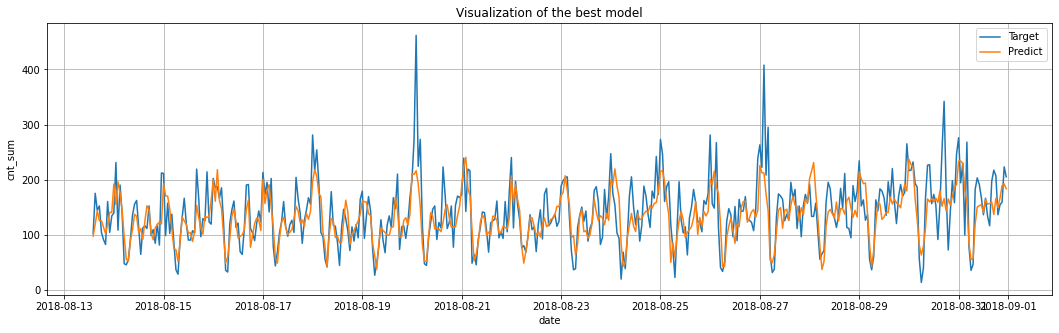

In [42]:
plt.figure(figsize = (18, 5))

plt.plot(y_test, label = 'Target')
plt.plot(y_test.index, predicted_target_test_lgbm, label = 'Predict')

plt.title('Visualization of the best model')

plt.legend()
plt.xlabel('date')
plt.ylabel('cnt_sum')
plt.grid(True)
plt.show()

We see that the model predicted the trend component well, but it coped with outliers worse.  
This can be seen at peak values, as well as at the end of the observation period, where the decomposition residue increased.

**General conclusion:**

In this project, a model was created to predict the number of taxi orders for the next hour

The project included the following stages:
 
  - data preparation
     - converted the date to the required datetime format for work
     - made data resampling by the hour
  - data analysis
      - studied the data in more detail
      - divided the time into components of trend, seasonality and residual and looked at them on different scales
  - model training, included two stages
      - generation of features (optimal set of features for further work was selected)
      - training of models, the stage included:
         - selection of hyperparameters
         - cross-validation
         - prediction
  - testing
     - Sweep all data into the final table
     - chose the best model
     - made a visualization of the prediction of the best model
 
**Final Model** - LGBM:
   - `learning_rate` - 0.1
   - `n_estimators` - 100
   - `RSME` - 41